In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
USE_DANISH_DATA = False
if USE_DANISH_DATA:
    data = pd.read_csv('data/DanishHousingMarket.csv')
    data = df_basic_process(data)
else:
    data = pd.read_csv('data/train.csv')



In [3]:
# Visualize key statistics
print("\nStatistical Summary of Numerical Features:")
print(data.describe())



Statistical Summary of Numerical Features:
                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904

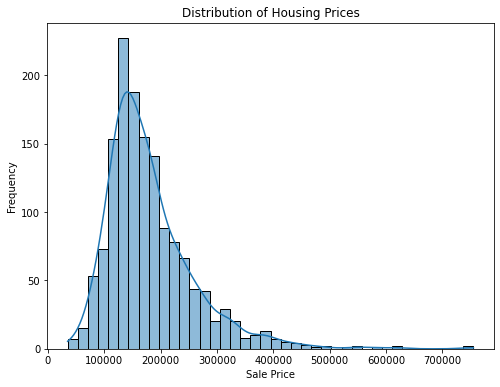

In [4]:
# Target variable: Visualize housing price distribution
target = 'SalePrice'  # Update this if your column has a different name
plt.figure(figsize=(8, 6))
sns.histplot(data[target], kde=True, bins=40)
plt.title('Distribution of Housing Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()

In [5]:
# 2. Hypothesis Testing
# Example: Test if mean price is significantly different from a hypothetical price
hypothetical_mean = 180000
t_stat, p_value = stats.ttest_1samp(data[target].fillna(data[target].mean()), hypothetical_mean)

print(f"\nT-Test for Hypothetical Mean (${hypothetical_mean}):")
print(f"T-Statistic = {t_stat:.3f}, P-Value = {p_value:.3f}")

if p_value < 0.05:
    print("We reject the null hypothesis: Prices significantly differ from the hypothetical mean.")
else:
    print("We fail to reject the null hypothesis.")


T-Test for Hypothetical Mean ($180000):
T-Statistic = 0.443, P-Value = 0.658
We fail to reject the null hypothesis.


In [4]:
from sklearn.linear_model import LassoCV
import numpy as np
#import pymc as pm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
#import arviz as az
from sklearn.decomposition import PCA
def preprocess_data(X: pd.DataFrame, use_pca: bool = False, n_components: int = 10):
    # Identify numeric and categorical columns
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = X.select_dtypes(include=['object']).columns

    # Define preprocessing pipelines
    numeric_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ])

    # Combine pipelines using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_pipeline, numeric_cols),
            ('cat', categorical_pipeline, categorical_cols)
        ]
    )

    # Fit and transform the data
    X_transformed = preprocessor.fit_transform(X)

    if use_pca:
        # Apply PCA to reduce dimensions
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_transformed)

        # Create column names for PCA components
        pca_features = [f"PCA_Component_{i+1}" for i in range(n_components)]

        # Convert PCA-transformed data to a DataFrame
        X_df = pd.DataFrame(X_pca, columns=pca_features)
    else:
        # Extract feature names dynamically
        # Numeric features
        numeric_features = list(numeric_cols)
        # Categorical features after one-hot encoding
        categorical_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)

        # Combine all feature names
        processed_features = numeric_features + list(categorical_features)

        # Convert transformed data to a DataFrame
        X_df = pd.DataFrame(X_transformed, columns=processed_features)
        print(f"Shape of X_transformed: {X_transformed.shape}")


    return X_df


In [7]:
if USE_DANISH_DATA: 
    data['PriceLogged'] = list(np.log(np.array(list(data.priceCash)))) # log the price so it has a normal distribution
    X = data.drop(columns=['priceCash', 'PriceLogged'], errors='ignore')  # Drop target columns
else: 
    data['PriceLogged'] = list(np.log(np.array(list(data.SalePrice)))) # log the price so it has a normal distribution
    X = data.drop(columns=['SalePrice', 'PriceLogged'], errors='ignore')  # Drop target columns

y = data['PriceLogged']  # Use log-transformed price as target

# preprocess the data
X_df = preprocess_data(X=X, use_pca=False)

# filter out the column which are not considered important
if not USE_DANISH_DATA: 
    important_features = find_best_features_with_lasso(X_df=X_df, y_df=y)
    # important_features = ["GrLivArea", "OverallQual", "YearBuilt", "TotalBsmtSF"]
    X_df = X_df[important_features]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

summary, trace, housing_model = get_bayesian_posterior_distribution(X_train=X_train, y_train=y_train, sigma=50000)
housing_model

ValueError: Shape of passed values is (1460, 1), indices imply (1460, 246)


Linear Regression Results:
Intercept: 180921.1959
Mean Squared Error: 0.0001
R-squared: 1.0000


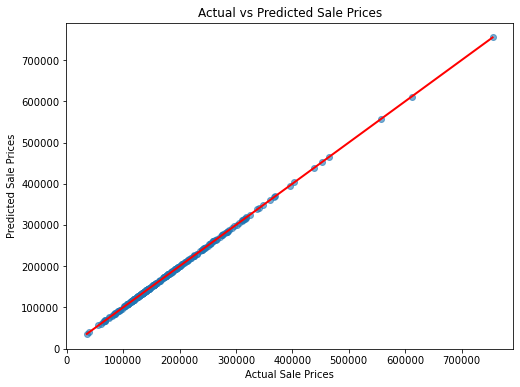

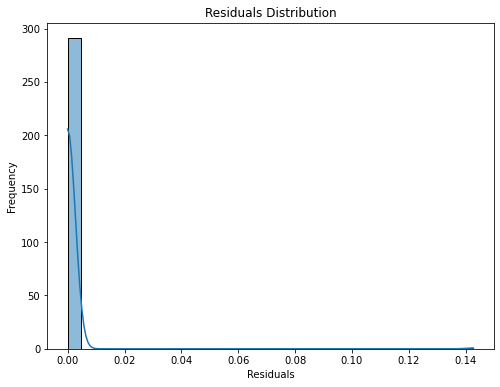


Shapiro-Wilk Test for Residual Normality: P-Value = 0.000
Residuals are not normally distributed.

Model Diagnostics and Results Completed!


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Train the Linear Regression Model
# Train the Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# 3. Model Performance and Diagnostics
print("\nLinear Regression Results:")
print(f"Intercept: {model.intercept_:.4f}")

# Performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")

# 4. Compare Predictions with Actual Prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', lw=2)  # 45-degree line
plt.xlabel('Actual Sale Prices')
plt.ylabel('Predicted Sale Prices')
plt.title('Actual vs Predicted Sale Prices')
plt.show()

# 5. Residual Diagnostics
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Shapiro-Wilk Test for Residual Normality
residual_stat, residual_p_value = stats.shapiro(residuals)
print(f"\nShapiro-Wilk Test for Residual Normality: P-Value = {residual_p_value:.3f}")
if residual_p_value < 0.05:
    print("Residuals are not normally distributed.")
else:
    print("Residuals are normally distributed.")

print("\nModel Diagnostics and Results Completed!")

Linear Regression Results with Log-Transformed Target:
Coefficient for 'GrLivArea': 0.0005
Intercept: 11.2468
Mean Squared Error (Log Scale): 0.0858
R-squared: 0.5402

Shapiro-Wilk Test for Residual Normality: P-Value = 0.000
Residuals are not normally distributed.

Model Diagnostics and Results Completed!

<h3>4.5 With Lasso


Cross-Validation R-squared Scores:
[0.99999998 0.99999998 0.99999998 0.99999997 0.99999998]
Mean R-squared (CV): 1.0000

Lasso Regression Results:
Best Alpha: 10
Mean Squared Error (Log Scale): 152.7395
R-squared: 1.0000


C:\Users\andre\AppData\Local\Temp/ipykernel_18876/2165745445.py:36: RuntimeWarning: overflow encountered in expm1
  y_pred_lasso_original = np.expm1(y_pred_lasso)  # Revert log1p transformation
c:\Users\andre\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)


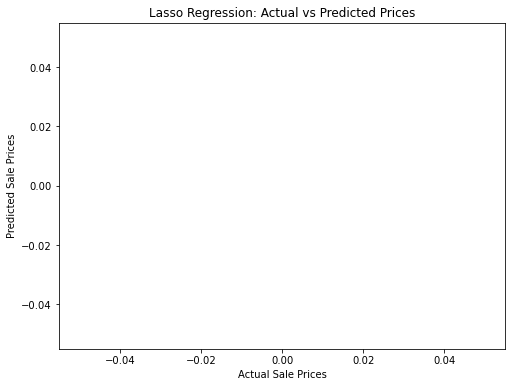


Top 10 Lasso Coefficients:
SalePrice      79403.033029
PriceLogged        1.159429
dtype: float64


In [11]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}  # Regularization strengths
lasso_model = Lasso(max_iter=10000)  # Increase iterations for convergence
grid_search = GridSearchCV(lasso_model, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Best Lasso model
best_lasso = grid_search.best_estimator_

# Cross-validation for evaluation
cv_scores = cross_val_score(best_lasso, X_train, y_train, cv=5, scoring='r2')
print("\nCross-Validation R-squared Scores:")
print(cv_scores)
print(f"Mean R-squared (CV): {np.mean(cv_scores):.4f}")

# Predict on test set
y_pred_lasso = best_lasso.predict(X_test)

# Evaluate performance
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("\nLasso Regression Results:")
print(f"Best Alpha: {grid_search.best_params_['alpha']}")
print(f"Mean Squared Error (Log Scale): {mse_lasso:.4f}")
print(f"R-squared: {r2_lasso:.4f}")

# Back-transform predictions to original scale
y_pred_lasso_original = np.expm1(y_pred_lasso)  # Revert log1p transformation
y_test_original = np.expm1(y_test)

# Compare predictions with actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred_lasso_original, alpha=0.6)
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()],
         color='red', lw=2)  # Ideal 45-degree line
plt.xlabel('Actual Sale Prices')
plt.ylabel('Predicted Sale Prices')
plt.title('Lasso Regression: Actual vs Predicted Prices')
plt.show()

# Print top 10 non-zero coefficients
lasso_coefficients = pd.Series(best_lasso.coef_, index=X_df.columns)
top_10_coefficients = lasso_coefficients[lasso_coefficients != 0].sort_values(ascending=False).head(10)
print("\nTop 10 Lasso Coefficients:")
print(top_10_coefficients)


In [15]:
def find_best_features_with_lasso(X_df:pd.DataFrame, y_df:pd.DataFrame):
    # Train Lasso model with cross-validation
    lasso = LassoCV(cv=5, random_state=42).fit(X_df, y_df)

    # Get feature importance
    lasso_coefficients = pd.Series(lasso.coef_, index=X_df.columns)
    important_features_to_use = lasso_coefficients[lasso_coefficients != 0]

    # sort the features in descending order of importance
    important_features_to_use = important_features_to_use.sort_values(ascending=False)
    # print("Lasso Selected Features:\n", important_features_to_use)

    important_features = list(important_features_to_use.index)
    return important_features

In [ ]:
find_best_features_with_lasso(X_df, y_df= y)

['SalePrice']

In [13]:
lasso_coefficients = pd.Series(best_lasso.coef_, index=X_df.columns)

# Identify dropped columns (coefficients set to zero)
dropped_columns = lasso_coefficients[lasso_coefficients == 0].index

print(len(dropped_columns))

print(f"Dropped Columns: {list(dropped_columns)}")

246
Dropped Columns: ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Pave', 'Alley_Pave', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'Utilities_NoSeWa', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neigh

Lasso Coefficients:
GrLivArea      0.000269
OverallQual    0.110932
YearBuilt      0.003135
TotalBsmtSF    0.000117
dtype: float64

<h3>Returning the RSME of the un-logged

In [9]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Back-transform predictions and actual values
y_pred_lasso_original = np.expm1(y_pred_lasso)
y_test_original = np.expm1(y_test)

# Calculate RMSE on the original scale
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_lasso_original))

print(f"Root Mean Squared Error (Original Scale): {rmse_original:.4f}")


Root Mean Squared Error (Original Scale): 28017.2202


Root Mean Squared Error (Original Scale): 32620.4262

Is this good?

In [10]:
avg_sale_price = data['SalePrice'].mean()
relative_error = (rmse_original / avg_sale_price) * 100
print(f"Relative Error: {relative_error:.2f}%")


Relative Error: 15.49%


Root Mean Squared Error (Original Scale): 32620.4262

<h3>1. Bootstrapping Coefficients

In [11]:
from sklearn.utils import resample
from sklearn.linear_model import Lasso
import pandas as pd

# Set up variables
n_bootstraps = 10
alpha = 0.05  # Confidence level = 95% (2.5% on each tail)
coefficients_bootstrap = []

# Bootstrapping
for i in range(n_bootstraps):
    # Resample the training data with replacement
    X_boot, y_boot = resample(X_train, y_train, random_state=i)
    
    # Ensure X_boot retains the correct column structure
    X_boot = pd.DataFrame(X_boot, columns=X_train.columns)
    
    # Train Lasso model on bootstrap sample
    lasso_model_boot = Lasso(alpha=grid_search.best_params_['alpha'], max_iter=10000)
    lasso_model_boot.fit(X_boot, y_boot)
    
    # Store coefficients
    coefficients_bootstrap.append(lasso_model_boot.coef_)

# Convert to DataFrame for easier analysis
coefficients_bootstrap = pd.DataFrame(coefficients_bootstrap, columns=predictors)

# Calculate confidence intervals
lower_bounds = coefficients_bootstrap.quantile(alpha / 2)
upper_bounds = coefficients_bootstrap.quantile(1 - alpha / 2)

# Print confidence intervals for each feature
print("Bootstrapped Confidence Intervals for Lasso Coefficients:")
for feature in predictors:
    print(f"{feature}: [{lower_bounds[feature]:.6f}, {upper_bounds[feature]:.6f}]")


c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.804e+00, tolerance: 1.842e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.700e+00, tolerance: 1.721e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.113e+00, toleranc

Bootstrapped Confidence Intervals for Lasso Coefficients:
1stFlrSF: [0.000168, 0.000276]
2ndFlrSF: [0.000158, 0.000210]
3SsnPorch: [0.000083, 0.000353]
Alley: [-0.009126, 0.007242]
BedroomAbvGr: [0.000000, 0.020629]
BldgType: [-0.017468, -0.003720]
BsmtCond: [0.000072, 0.022004]
BsmtExposure: [-0.015309, -0.006136]
BsmtFinSF1: [0.000047, 0.000144]
BsmtFinSF2: [0.000075, 0.000176]
BsmtFinType1: [-0.014830, -0.002331]
BsmtFinType2: [0.000195, 0.011099]
BsmtFullBath: [0.020180, 0.075346]
BsmtHalfBath: [0.000000, 0.001815]
BsmtQual: [-0.034105, -0.016735]
BsmtUnfSF: [0.000069, 0.000107]
CentralAir: [0.005758, 0.089077]
Condition1: [-0.004033, 0.004838]
Condition2: [-0.349156, -0.005943]
Electrical: [-0.008169, 0.005244]
EnclosedPorch: [-0.000007, 0.000207]
ExterCond: [-0.003549, 0.017912]
ExterQual: [-0.007517, 0.012989]
Exterior1st: [-0.011510, -0.002743]
Exterior2nd: [0.001061, 0.009198]
Fence: [0.000314, 0.010690]
FireplaceQu: [-0.014345, -0.001169]
Fireplaces: [0.001316, 0.046690]
Foun

c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.664e+00, tolerance: 1.980e-02
  model = cd_fast.enet_coordinate_descent(


Bootstrapped Confidence Intervals for Lasso Coefficients:
GrLivArea: [0.000216, 0.000331]
OverallQual: [0.088705, 0.131872]
YearBuilt: [0.002720, 0.003594]
TotalBsmtSF: [0.000016, 0.000212]

In [12]:
r2_scores = []
mse_scores = []

# Bootstrapping metrics
for i in range(n_bootstraps):
    X_boot, y_boot = resample(X_train, y_train, random_state=i)
    lasso_model_boot = Lasso(alpha=grid_search.best_params_['alpha'], max_iter=10000)
    lasso_model_boot.fit(X_boot, y_boot)
    y_pred_boot = lasso_model_boot.predict(X_test)
    
    r2_scores.append(r2_score(y_test, y_pred_boot))
    mse_scores.append(mean_squared_error(y_test, y_pred_boot))

# Calculate confidence intervals
r2_lower, r2_upper = np.percentile(r2_scores, [2.5, 97.5])
mse_lower, mse_upper = np.percentile(mse_scores, [2.5, 97.5])

print(f"95% CI for R-squared: [{r2_lower:.4f}, {r2_upper:.4f}]")
print(f"95% CI for MSE: [{mse_lower:.4f}, {mse_upper:.4f}]")


c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.804e+00, tolerance: 1.842e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.700e+00, tolerance: 1.721e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.113e+00, toleranc

95% CI for R-squared: [0.8250, 0.8893]
95% CI for MSE: [0.0207, 0.0327]


c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.664e+00, tolerance: 1.980e-02
  model = cd_fast.enet_coordinate_descent(


95% CI for R-squared: [0.8052, 0.8448]
95% CI for MSE: [0.0290, 0.0364]

<h3>GPT-Optimized

Best Alpha: 0.0016768329368110084
RMSE (Log Scale): 0.1530
RMSE (Original Scale): 28067.15


c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.547e+00, tolerance: 1.781e-02
  model = cd_fast.enet_coordinate_descent(


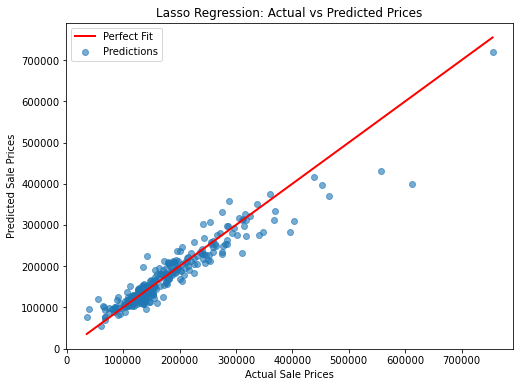

c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.109e+01, tolerance: 2.119e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.121e+01, tolerance: 2.100e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.065e+01, toleranc

Mean CV RMSE (Log Scale): 0.1476


c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.105e+01, tolerance: 2.091e-02
  model = cd_fast.enet_coordinate_descent(


In [13]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Hyperparameter Tuning with Cross-Validation
param_grid = {'alpha': np.logspace(-4, 1, 50)}  # Finer range of alpha values
lasso_model = Lasso(max_iter=10000)
grid_search = GridSearchCV(lasso_model, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_lasso = grid_search.best_estimator_

# Step 3: Model Performance
# Predict on test set
y_pred_lasso = best_lasso.predict(X_test)

# Evaluate RMSE on log scale
mse_lasso_log = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso_log = np.sqrt(mse_lasso_log)
print(f"Best Alpha: {grid_search.best_params_['alpha']}")
print(f"RMSE (Log Scale): {rmse_lasso_log:.4f}")

# Back-transform predictions
y_pred_lasso_original = np.expm1(y_pred_lasso)
y_test_original = np.expm1(y_test)

# Calculate RMSE on original scale
rmse_lasso_original = np.sqrt(mean_squared_error(y_test_original, y_pred_lasso_original))
print(f"RMSE (Original Scale): {rmse_lasso_original:.2f}")

# Plot Actual vs Predicted Prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred_lasso_original, alpha=0.6, label='Predictions')
plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], color='red', lw=2, label='Perfect Fit')
plt.xlabel('Actual Sale Prices')
plt.ylabel('Predicted Sale Prices')
plt.title('Lasso Regression: Actual vs Predicted Prices')
plt.legend()
plt.show()

# Step 4: Cross-Validation Performance
cv_scores = cross_val_score(best_lasso, X, y, cv=10, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f"Mean CV RMSE (Log Scale): {cv_rmse.mean():.4f}")


Best Alpha: 0.0021209508879201904
RMSE (Log Scale): 0.1698
RMSE (Original Scale): 31813.14

Mean CV RMSE (Log Scale): 0.1693